In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets.mnist import MNIST
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import optim
import time
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
batch_size = 64
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class ArcFaceLoss(nn.Module):
    def __init__(self, num_classes, embedding_size, margin, scale):
        """
        ArcFace: Additive Angular Margin Loss for Deep Face Recognition
        (https://arxiv.org/pdf/1801.07698.pdf)
        Args:
            num_classes: The number of classes in your training dataset
            embedding_size: The size of the embeddings that you pass into
            margin: m in the paper, the angular margin penalty in radians
            scale: s in the paper, feature scale
        """
        super().__init__()
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.margin = margin
        self.scale = scale
        
        self.W = torch.nn.Parameter(torch.Tensor(num_classes, embedding_size))
        nn.init.xavier_normal_(self.W)
        
    def forward(self, embeddings, labels):
        """
        Args:
            embeddings: (None, embedding_size)
            labels: (None,)
        Returns:
            loss: scalar
        """
        cosine = self.get_cosine(embeddings) # (None, n_classes)
        mask = self.get_target_mask(labels) # (None, n_classes)
        cosine_of_target_classes = cosine[mask == 1] # (None, )
        modified_cosine_of_target_classes = self.modify_cosine_of_target_classes(
            cosine_of_target_classes
        ) # (None, )
        diff = (modified_cosine_of_target_classes - cosine_of_target_classes).unsqueeze(1) # (None,1)
        logits = cosine + (mask * diff) # (None, n_classes)
        logits = self.scale_logits(logits) # (None, n_classes)
        return logits
        
    def get_cosine(self, embeddings):
        """
        Args:
            embeddings: (None, embedding_size)
        Returns:
            cosine: (None, n_classes)
        """
        cosine = F.linear(F.normalize(embeddings), F.normalize(self.W))
        return cosine
    
    def get_target_mask(self, labels):
        """
        Args:
            labels: (None,)
        Returns:
            mask: (None, n_classes)
        """
        batch_size = labels.size(0)
        onehot = torch.zeros(batch_size, self.num_classes, device=labels.device)
        onehot.scatter_(1, labels.unsqueeze(-1), 1)
        return onehot
        
    def modify_cosine_of_target_classes(self, cosine_of_target_classes):
        """
        Args:
            cosine_of_target_classes: (None,)
        Returns:
            modified_cosine_of_target_classes: (None,)
        """
        eps = 1e-6
        # theta in the paper
        angles = torch.acos(torch.clamp(cosine_of_target_classes, -1 + eps, 1 - eps))
        return torch.cos(angles + self.margin)
    
    def scale_logits(self, logits):
        """
        Args:
            logits: (None, n_classes)
        Returns:
            scaled_logits: (None, n_classes)
        """
        return logits * self.scale
    
class SoftmaxLoss(nn.Module):
    def __init__(self, num_classes, embedding_size):
        """
        Regular softmax loss (1 fc layer without bias + CrossEntropyLoss)
        Args:
            num_classes: The number of classes in your training dataset
            embedding_size: The size of the embeddings that you pass into
        """
        super().__init__()
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        
        self.W = torch.nn.Parameter(torch.Tensor(num_classes, embedding_size))
        nn.init.xavier_normal_(self.W)
        
    def forward(self, embeddings, labels):
        """
        Args:
            embeddings: (None, embedding_size)
            labels: (None,)
        Returns:
            loss: scalar
        """
        logits = F.linear(embeddings, self.W)
        return nn.CrossEntropyLoss()(logits, labels)

In [5]:
class Embedder(nn.Module):
    def __init__(self, embedding_size):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained = False)
        self.dropout = nn.Dropout(0.5)
        
        self.classifier = nn.Linear(1000, embedding_size)

    def forward(self, images):
        outputs = self.model(images)
        outputs = self.dropout(outputs)
        outputs = self.classifier(outputs)
        return outputs

In [6]:
embedding_size = 3
max_epochs = 100


embedder = Embedder(embedding_size=embedding_size).to(device)
arcface = ArcFaceLoss(num_classes=10, embedding_size=embedding_size,margin=0.3, scale=30.0).to(device)

optimizer = optim.Adam(embedder.parameters(), lr=1e-3 ) 
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.9)


start = time.time()
for epoch in range(max_epochs):
    e_time = time.time()
    for i, (images, labels) in enumerate(trainloader):
        embedder.train()
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        embeddings = embedder(images)
        
        logits = arcface(embeddings, labels)
        loss = criterion(logits, labels)
        loss.backward() 
        optimizer.step() 
        
        if (i+1) % 64 == 0:
              print(f'Epoch: {epoch} - Batch: {i*batch_size} - Loss: {loss:.6f} - Time:{time.time() - e_time}')

/home/ielab/anaconda3/envs/arcface/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ielab/anaconda3/envs/arcface/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch: 0 - Batch: 4032 - Loss: 20.254032 - Time:2.0299196243286133
Epoch: 0 - Batch: 8128 - Loss: 20.429539 - Time:2.734229564666748
Epoch: 0 - Batch: 12224 - Loss: 19.283665 - Time:3.4362411499023438
Epoch: 0 - Batch: 16320 - Loss: 20.338158 - Time:4.138391017913818
Epoch: 0 - Batch: 20416 - Loss: 18.978168 - Time:4.840424060821533
Epoch: 0 - Batch: 24512 - Loss: 20.366917 - Time:5.5425920486450195
Epoch: 0 - Batch: 28608 - Loss: 24.638737 - Time:6.244499444961548
Epoch: 0 - Batch: 32704 - Loss: 20.421177 - Time:6.9467902183532715
Epoch: 0 - Batch: 36800 - Loss: 18.676422 - Time:7.6492018699646
Epoch: 0 - Batch: 40896 - Loss: 19.424679 - Time:8.351746320724487
Epoch: 0 - Batch: 44992 - Loss: 21.309710 - Time:9.053866624832153
Epoch: 0 - Batch: 49088 - Loss: 19.586058 - Time:9.755962610244751
Epoch: 1 - Batch: 4032 - Loss: 21.728928 - Time:0.8259456157684326
Epoch: 1 - Batch: 8128 - Loss: 18.039679 - Time:1.5294239521026611
Epoch: 1 - Batch: 12224 - Loss: 21.146069 - Time:2.23213100433

Epoch: 10 - Batch: 16320 - Loss: 11.888613 - Time:2.956869125366211
Epoch: 10 - Batch: 20416 - Loss: 15.961338 - Time:3.661105155944824
Epoch: 10 - Batch: 24512 - Loss: 13.075892 - Time:4.36492919921875
Epoch: 10 - Batch: 28608 - Loss: 15.958292 - Time:5.068487882614136
Epoch: 10 - Batch: 32704 - Loss: 13.114136 - Time:5.772146463394165
Epoch: 10 - Batch: 36800 - Loss: 15.238430 - Time:6.474971532821655
Epoch: 10 - Batch: 40896 - Loss: 13.817063 - Time:7.177868604660034
Epoch: 10 - Batch: 44992 - Loss: 10.800670 - Time:7.880610942840576
Epoch: 10 - Batch: 49088 - Loss: 12.555397 - Time:8.583324193954468
Epoch: 11 - Batch: 4032 - Loss: 15.416924 - Time:0.8266222476959229
Epoch: 11 - Batch: 8128 - Loss: 13.582319 - Time:1.529017686843872
Epoch: 11 - Batch: 12224 - Loss: 13.034013 - Time:2.23000168800354
Epoch: 11 - Batch: 16320 - Loss: 13.232834 - Time:2.932460308074951
Epoch: 11 - Batch: 20416 - Loss: 15.143223 - Time:3.6334125995635986
Epoch: 11 - Batch: 24512 - Loss: 14.856262 - Time:

Epoch: 20 - Batch: 20416 - Loss: 9.385805 - Time:3.6428449153900146
Epoch: 20 - Batch: 24512 - Loss: 15.007479 - Time:4.345006465911865
Epoch: 20 - Batch: 28608 - Loss: 10.876088 - Time:5.0471742153167725
Epoch: 20 - Batch: 32704 - Loss: 15.683661 - Time:5.749401569366455
Epoch: 20 - Batch: 36800 - Loss: 9.411394 - Time:6.451650619506836
Epoch: 20 - Batch: 40896 - Loss: 8.650539 - Time:7.153887987136841
Epoch: 20 - Batch: 44992 - Loss: 13.038181 - Time:7.8561646938323975
Epoch: 20 - Batch: 49088 - Loss: 11.971324 - Time:8.55849313735962
Epoch: 21 - Batch: 4032 - Loss: 9.382333 - Time:0.8242440223693848
Epoch: 21 - Batch: 8128 - Loss: 8.991679 - Time:1.5279157161712646
Epoch: 21 - Batch: 12224 - Loss: 13.456493 - Time:2.2308216094970703
Epoch: 21 - Batch: 16320 - Loss: 12.463713 - Time:2.931609869003296
Epoch: 21 - Batch: 20416 - Loss: 10.435075 - Time:3.632236957550049
Epoch: 21 - Batch: 24512 - Loss: 7.793863 - Time:4.333161354064941
Epoch: 21 - Batch: 28608 - Loss: 10.515879 - Time:5

Epoch: 30 - Batch: 28608 - Loss: 9.150251 - Time:5.055150985717773
Epoch: 30 - Batch: 32704 - Loss: 5.937417 - Time:5.757958173751831
Epoch: 30 - Batch: 36800 - Loss: 6.189302 - Time:6.461139440536499
Epoch: 30 - Batch: 40896 - Loss: 7.171853 - Time:7.163227319717407
Epoch: 30 - Batch: 44992 - Loss: 8.902533 - Time:7.86402702331543
Epoch: 30 - Batch: 49088 - Loss: 8.018732 - Time:8.56649136543274
Epoch: 31 - Batch: 4032 - Loss: 7.458755 - Time:0.8309040069580078
Epoch: 31 - Batch: 8128 - Loss: 8.842946 - Time:1.5346477031707764
Epoch: 31 - Batch: 12224 - Loss: 10.972175 - Time:2.2379677295684814
Epoch: 31 - Batch: 16320 - Loss: 8.369279 - Time:2.9416825771331787
Epoch: 31 - Batch: 20416 - Loss: 7.420489 - Time:3.6449642181396484
Epoch: 31 - Batch: 24512 - Loss: 9.374890 - Time:4.3448004722595215
Epoch: 31 - Batch: 28608 - Loss: 10.991565 - Time:5.045894622802734
Epoch: 31 - Batch: 32704 - Loss: 6.819737 - Time:5.746354818344116
Epoch: 31 - Batch: 36800 - Loss: 6.643807 - Time:6.4470119

Epoch: 40 - Batch: 40896 - Loss: 5.848817 - Time:7.169812202453613
Epoch: 40 - Batch: 44992 - Loss: 6.714881 - Time:7.871948480606079
Epoch: 40 - Batch: 49088 - Loss: 6.732460 - Time:8.573843717575073
Epoch: 41 - Batch: 4032 - Loss: 9.445217 - Time:0.8343453407287598
Epoch: 41 - Batch: 8128 - Loss: 6.286837 - Time:1.5372703075408936
Epoch: 41 - Batch: 12224 - Loss: 5.817110 - Time:2.2398571968078613
Epoch: 41 - Batch: 16320 - Loss: 5.944047 - Time:2.9425790309906006
Epoch: 41 - Batch: 20416 - Loss: 5.160817 - Time:3.643550395965576
Epoch: 41 - Batch: 24512 - Loss: 5.411529 - Time:4.345381736755371
Epoch: 41 - Batch: 28608 - Loss: 7.283687 - Time:5.047656536102295
Epoch: 41 - Batch: 32704 - Loss: 5.217251 - Time:5.749030828475952
Epoch: 41 - Batch: 36800 - Loss: 7.362613 - Time:6.45102858543396
Epoch: 41 - Batch: 40896 - Loss: 7.432185 - Time:7.152942657470703
Epoch: 41 - Batch: 44992 - Loss: 4.187194 - Time:7.855347394943237
Epoch: 41 - Batch: 49088 - Loss: 5.841122 - Time:8.5572605133

Epoch: 51 - Batch: 4032 - Loss: 4.290342 - Time:0.8235898017883301
Epoch: 51 - Batch: 8128 - Loss: 5.231965 - Time:1.5267479419708252
Epoch: 51 - Batch: 12224 - Loss: 3.679901 - Time:2.22999906539917
Epoch: 51 - Batch: 16320 - Loss: 3.905001 - Time:2.9326207637786865
Epoch: 51 - Batch: 20416 - Loss: 3.701598 - Time:3.634911060333252
Epoch: 51 - Batch: 24512 - Loss: 3.975380 - Time:4.337392568588257
Epoch: 51 - Batch: 28608 - Loss: 7.461835 - Time:5.03953218460083
Epoch: 51 - Batch: 32704 - Loss: 5.264207 - Time:5.741995334625244
Epoch: 51 - Batch: 36800 - Loss: 3.485125 - Time:6.444526433944702
Epoch: 51 - Batch: 40896 - Loss: 6.707502 - Time:7.147009372711182
Epoch: 51 - Batch: 44992 - Loss: 5.622112 - Time:7.849488258361816
Epoch: 51 - Batch: 49088 - Loss: 4.921404 - Time:8.551671504974365
Epoch: 52 - Batch: 4032 - Loss: 3.123008 - Time:0.8255517482757568
Epoch: 52 - Batch: 8128 - Loss: 4.849574 - Time:1.5291895866394043
Epoch: 52 - Batch: 12224 - Loss: 2.997803 - Time:2.231742858886

Epoch: 61 - Batch: 16320 - Loss: 2.545688 - Time:2.94646954536438
Epoch: 61 - Batch: 20416 - Loss: 2.198983 - Time:3.6498489379882812
Epoch: 61 - Batch: 24512 - Loss: 2.940552 - Time:4.352946758270264
Epoch: 61 - Batch: 28608 - Loss: 3.191554 - Time:5.055845260620117
Epoch: 61 - Batch: 32704 - Loss: 2.986877 - Time:5.759173154830933
Epoch: 61 - Batch: 36800 - Loss: 5.768621 - Time:6.461818695068359
Epoch: 61 - Batch: 40896 - Loss: 6.480518 - Time:7.165487289428711
Epoch: 61 - Batch: 44992 - Loss: 5.962932 - Time:7.8687193393707275
Epoch: 61 - Batch: 49088 - Loss: 3.714528 - Time:8.572006702423096
Epoch: 62 - Batch: 4032 - Loss: 2.599429 - Time:0.8403549194335938
Epoch: 62 - Batch: 8128 - Loss: 3.277789 - Time:1.543898105621338
Epoch: 62 - Batch: 12224 - Loss: 4.644175 - Time:2.247117757797241
Epoch: 62 - Batch: 16320 - Loss: 4.484583 - Time:2.949906349182129
Epoch: 62 - Batch: 20416 - Loss: 4.071628 - Time:3.6512062549591064
Epoch: 62 - Batch: 24512 - Loss: 5.149380 - Time:4.3525183200

Epoch: 71 - Batch: 28608 - Loss: 3.497162 - Time:5.058186769485474
Epoch: 71 - Batch: 32704 - Loss: 1.521115 - Time:5.760684251785278
Epoch: 71 - Batch: 36800 - Loss: 0.441845 - Time:6.463616609573364
Epoch: 71 - Batch: 40896 - Loss: 1.127035 - Time:7.166217088699341
Epoch: 71 - Batch: 44992 - Loss: 1.484337 - Time:7.868396043777466
Epoch: 71 - Batch: 49088 - Loss: 2.385528 - Time:8.571351289749146
Epoch: 72 - Batch: 4032 - Loss: 1.740959 - Time:0.8270657062530518
Epoch: 72 - Batch: 8128 - Loss: 2.011349 - Time:1.530919075012207
Epoch: 72 - Batch: 12224 - Loss: 1.148262 - Time:2.2387266159057617
Epoch: 72 - Batch: 16320 - Loss: 1.229860 - Time:2.941774845123291
Epoch: 72 - Batch: 20416 - Loss: 2.342993 - Time:3.6447012424468994
Epoch: 72 - Batch: 24512 - Loss: 3.991041 - Time:4.347659349441528
Epoch: 72 - Batch: 28608 - Loss: 0.850949 - Time:5.050302982330322
Epoch: 72 - Batch: 32704 - Loss: 2.024448 - Time:5.75359582901001
Epoch: 72 - Batch: 36800 - Loss: 2.758600 - Time:6.45681071281

Epoch: 81 - Batch: 40896 - Loss: 1.986303 - Time:7.179445743560791
Epoch: 81 - Batch: 44992 - Loss: 1.101251 - Time:7.882234573364258
Epoch: 81 - Batch: 49088 - Loss: 1.499440 - Time:8.58453893661499
Epoch: 82 - Batch: 4032 - Loss: 0.840157 - Time:0.8643233776092529
Epoch: 82 - Batch: 8128 - Loss: 1.509506 - Time:1.5682401657104492
Epoch: 82 - Batch: 12224 - Loss: 1.530539 - Time:2.272160291671753
Epoch: 82 - Batch: 16320 - Loss: 0.464247 - Time:2.9753308296203613
Epoch: 82 - Batch: 20416 - Loss: 0.728355 - Time:3.6790385246276855
Epoch: 82 - Batch: 24512 - Loss: 0.669021 - Time:4.382893800735474
Epoch: 82 - Batch: 28608 - Loss: 1.522164 - Time:5.0876383781433105
Epoch: 82 - Batch: 32704 - Loss: 0.963917 - Time:5.790279865264893
Epoch: 82 - Batch: 36800 - Loss: 1.326639 - Time:6.492923259735107
Epoch: 82 - Batch: 40896 - Loss: 0.786066 - Time:7.195645093917847
Epoch: 82 - Batch: 44992 - Loss: 0.830744 - Time:7.898138046264648
Epoch: 82 - Batch: 49088 - Loss: 1.026947 - Time:8.600549221

Epoch: 92 - Batch: 4032 - Loss: 0.662895 - Time:0.8312926292419434
Epoch: 92 - Batch: 8128 - Loss: 1.737229 - Time:1.534816026687622
Epoch: 92 - Batch: 12224 - Loss: 1.287797 - Time:2.2377912998199463
Epoch: 92 - Batch: 16320 - Loss: 0.407785 - Time:2.941014051437378
Epoch: 92 - Batch: 20416 - Loss: 1.526645 - Time:3.64395809173584
Epoch: 92 - Batch: 24512 - Loss: 2.044668 - Time:4.346641540527344
Epoch: 92 - Batch: 28608 - Loss: 1.553612 - Time:5.04927659034729
Epoch: 92 - Batch: 32704 - Loss: 1.757733 - Time:5.752051115036011
Epoch: 92 - Batch: 36800 - Loss: 3.022948 - Time:6.4547107219696045
Epoch: 92 - Batch: 40896 - Loss: 0.699625 - Time:7.159595966339111
Epoch: 92 - Batch: 44992 - Loss: 1.605144 - Time:7.862494230270386
Epoch: 92 - Batch: 49088 - Loss: 1.970075 - Time:8.56547999382019
Epoch: 93 - Batch: 4032 - Loss: 1.446689 - Time:0.8502440452575684
Epoch: 93 - Batch: 8128 - Loss: 1.149611 - Time:1.5542514324188232
Epoch: 93 - Batch: 12224 - Loss: 0.512471 - Time:2.2570874691009

In [7]:
import plotly.express as px

In [8]:
import pandas as pd

In [9]:
"""
train_results = []
train_labels = []
df = pd.DataFrame(columns=['x', 'y', 'z', 'label'])

embedder.eval()
with torch.no_grad():
    for img, label in trainloader:
        img = img.cuda()
        train_results.append(embedder(img).cpu().detach().numpy())
        train_labels.append(label)
        
train_results = np.concatenate(train_results)
train_labels = np.concatenate(train_labels)

for label in np.unique(train_labels):        
    tmp = train_results[train_labels==label]
    dict_ = {'x':tmp[:,0], 'y':tmp[:,1], 'z':tmp[:,2], 'label': label}
    df.loc[label]=[tmp[:,0], tmp[:,1], tmp[:,2], label]
""""""

In [67]:
with torch.no_grad():
        for imgs, labels in trainloader:
            outputs = embedder(img)
            outputs = [outputs for output in outputs]
            print(imgs.shape)
            print(outputs)
            print(labels.shape)
            print()

torch.Size([64, 3, 32, 32])
[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,

[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


[tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],
        [-19420.2891,  -7740.7178,  -6214.8579],
        [ -9847.9648,  -6775.2920,   2967.8452],
        [ -5039.4170,   3462.8289,   9938.6602],
        [  4074.5654,   6798.2378,  -3107.0574],
        [-14399.8076,  -8637.6494,   8795.8721],
        [-12039.6709,  -7207.0161,   7240.6768],
        [ -6557.4141,  -3966.7151,   3886.6711],
        [-13347.1816,  -5349.6919,  -3596.2307],
        [-12333.8867,  -7336.3730,   7522.4766],
        [  3600.8030,     92.2512,   3806.1326],
        [  -983.6082,   -365.5731,   -733.4011],
        [ -1440.9030,   2293.7388,   4460.1050]], device='cuda:0'), tensor([[ -1416.3358,   1173.4700,   7296.2515],
        [  4590.5195,   -936.2741,   2814.8552],
        [-10108.2773,  -4858.1382,  -3466.9517],
        [  4248.8130,   4550.1011,  -3447.7642],


KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


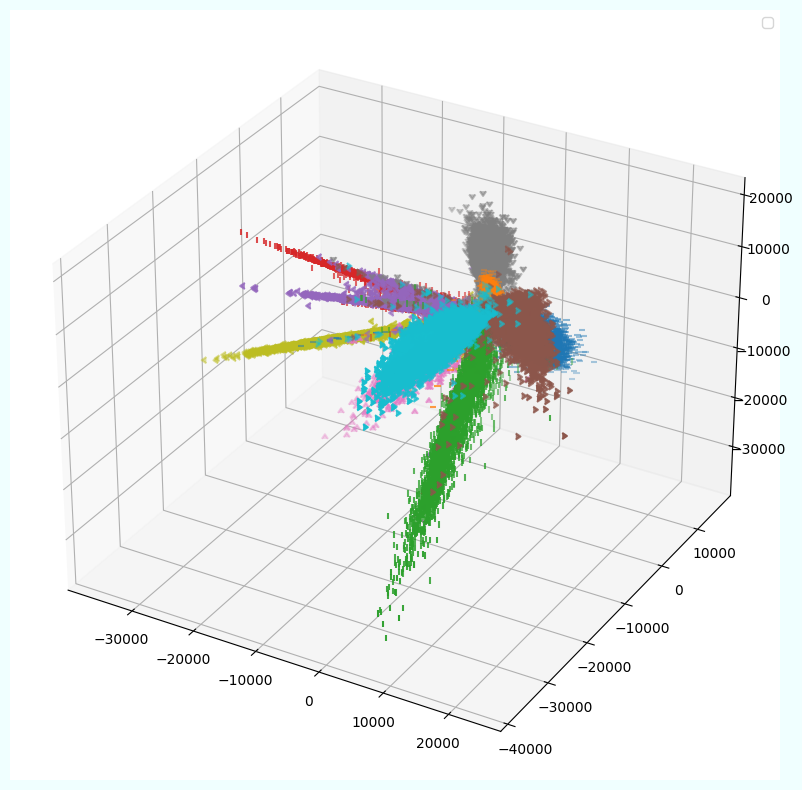

In [71]:
train_results = []
train_labels = []

embedder.eval()
with torch.no_grad():
    for img, label in trainloader:
        img = img.cuda()
        train_results.append(embedder(img).cpu().detach().numpy())
        train_labels.append(label)
        
train_results = np.concatenate(train_results)
train_labels = np.concatenate(train_labels)


plt.figure(figsize=(15, 10), facecolor="azure")
ax = plt.axes(projection ="3d")

for label in np.unique(train_labels):        
    tmp = train_results[train_labels==label]
    ax.scatter(tmp[:, 0], tmp[:, 1], tmp[:,2], marker=label)

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


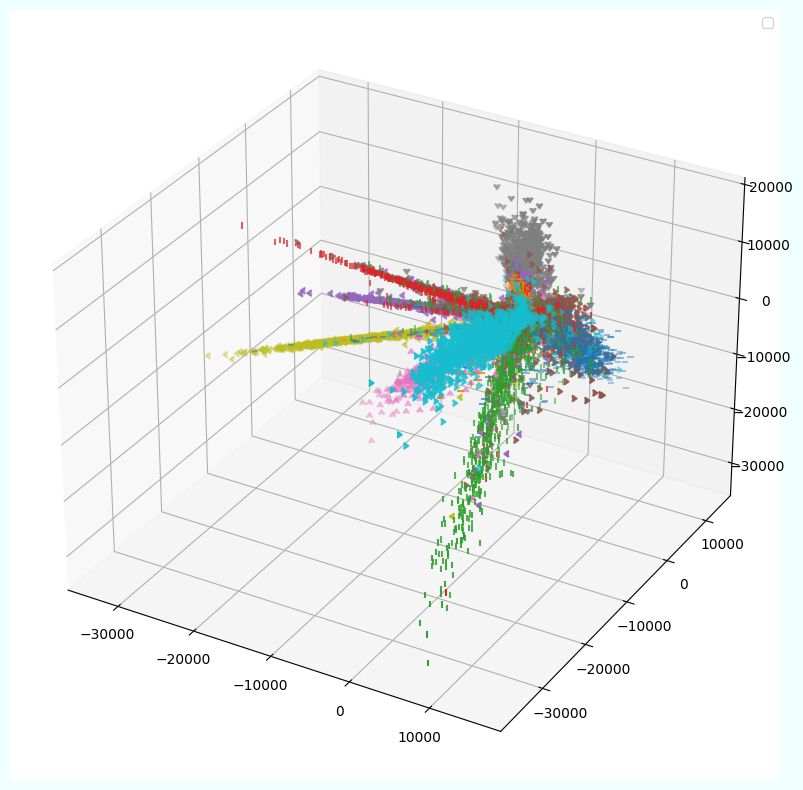

In [74]:
test_results = []
test_labels = []

embedder.eval()
with torch.no_grad():
    for img, label in testloader:
        img = img.cuda()
        test_results.append(embedder(img).cpu().detach().numpy())
        test_labels.append(label)
        
test_results = np.concatenate(test_results)
test_labels = np.concatenate(test_labels)


plt.figure(figsize=(15, 10), facecolor="azure")
ax = plt.axes(projection ="3d")

for label in np.unique(test_labels):        
    tmp = test_results[test_labels==label]
    ax.scatter(tmp[:, 0], tmp[:, 1], tmp[:,2], marker=label)

plt.legend()
plt.show()

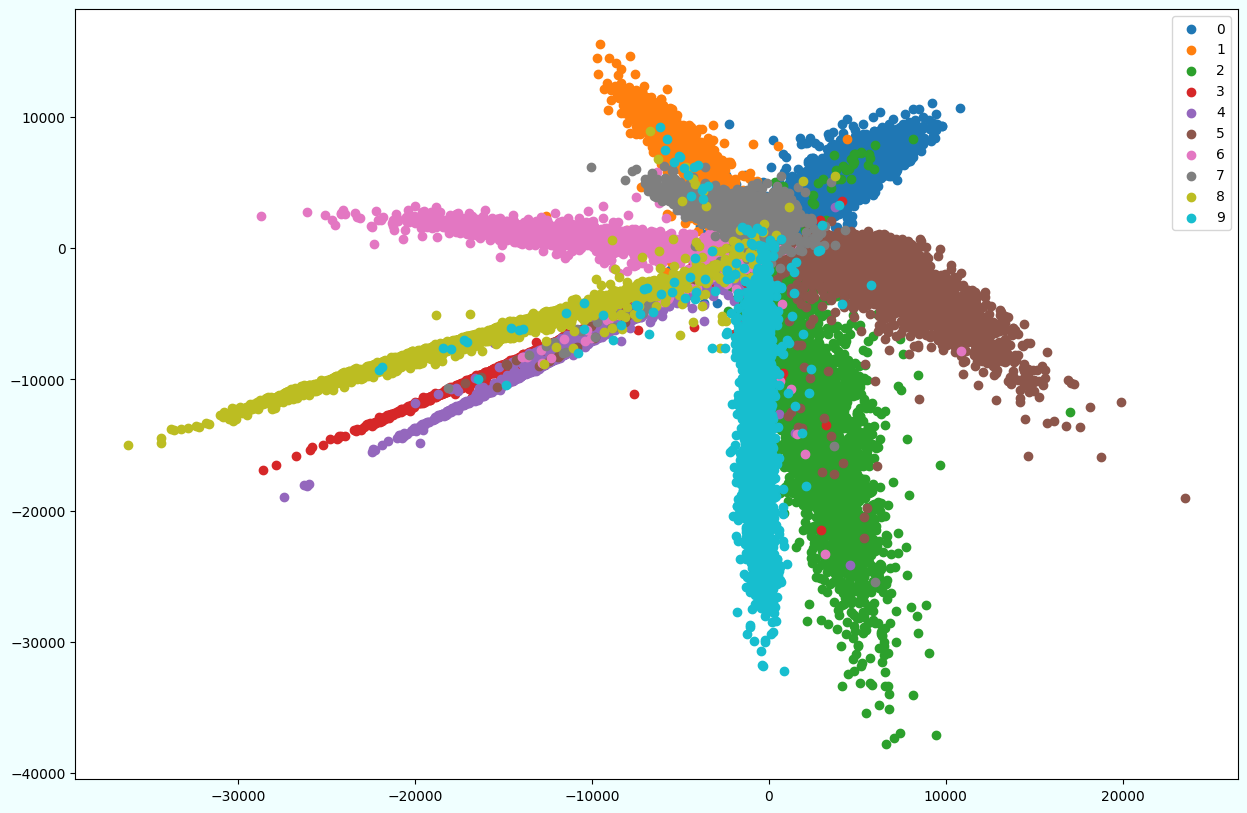

In [12]:
train_results = []
train_labels = []

embedder.eval()
with torch.no_grad():
  for img, label in trainloader:
    img = img.cuda()
    train_results.append(embedder(img).cpu().detach().numpy())
    train_labels.append(label)
        
train_results = np.concatenate(train_results)
train_labels = np.concatenate(train_labels)

plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(train_labels):        
  tmp = train_results[train_labels==label]
  plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

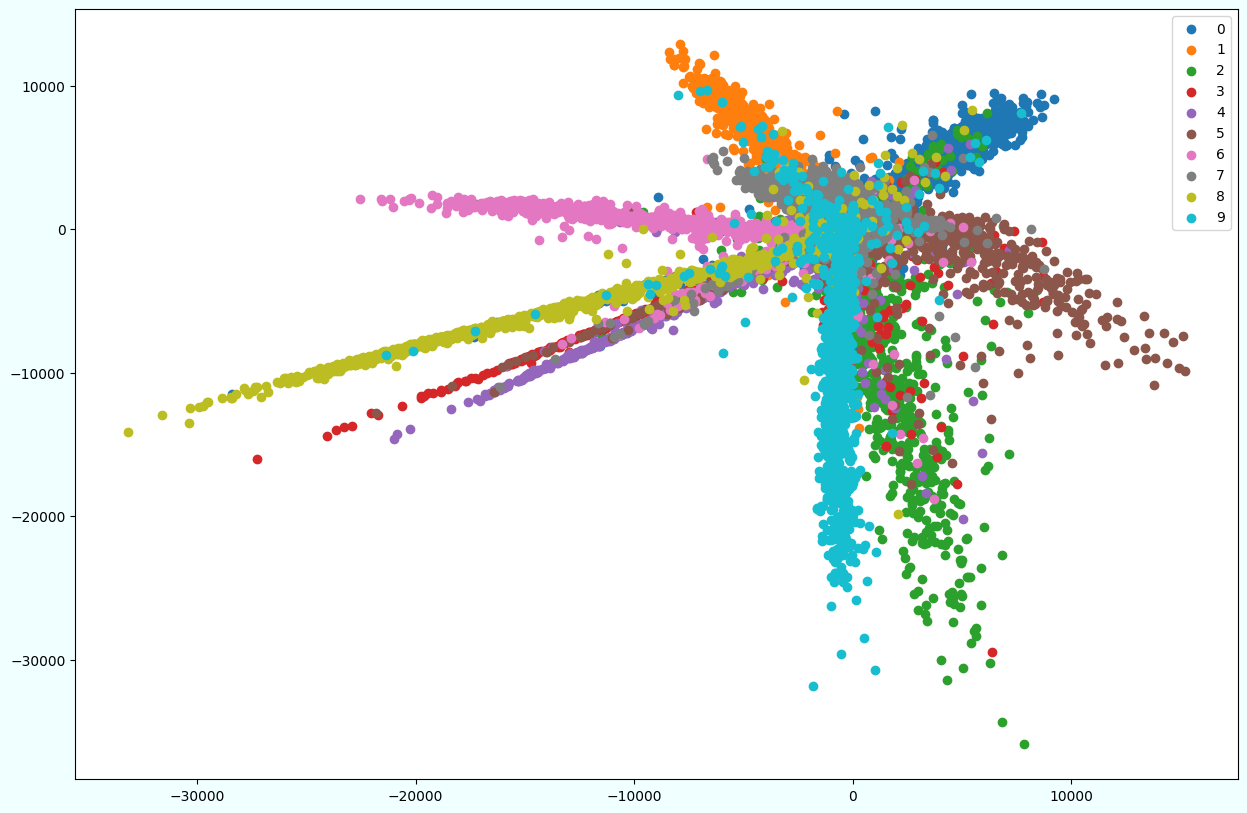

In [13]:
test_results = []
test_labels = []

embedder.eval()
with torch.no_grad():
  for img, label in testloader:
    img = img.cuda()
    test_results.append(embedder(img).cpu().detach().numpy())
    test_labels.append(label)
        
test_results = np.concatenate(test_results)
test_labels = np.concatenate(test_labels)

plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(test_labels):        
  tmp = test_results[test_labels==label]
  plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

In [90]:
from sklearn.neighbors import KNeighborsClassifier


# kNN 모델 선언
k = 3
model = KNeighborsClassifier(n_neighbors = k)
# 모델 학습
model.fit(train_results, train_labels)

KNeighborsClassifier(n_neighbors=3)

In [113]:
train_pred = model.predict(train_results)
(train_pred == train_labels).mean()

0.97636

In [114]:
test_pred = model.predict(test_results)
(test_pred == test_labels).mean()

0.7132